# Дипломный проект по теме "Поиск семантического сходства словосочетаний в задаче сопоставления видов деятельности компаний с нормативами обращения ТКО субъекта РФ"


**Цель:** подобрать и обучить модель машинного обучения для получения максимально высокой точности в сопоставлении текстов по теме.  

**Задачи:**  
1. Загрузка данных 
2. EDA   
3. Предобработка данных
4. Работа с моделью
5. Выводы

**Мера оценки качества:** F1  

Загрузка необходимых библиотек:

In [1]:
import re
import torch
import warnings
import numpy as np
import transformers
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import notebook
from keras.models import Model
from keras.optimizers import Adam
from keras.models import Sequential
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from keras.layers import Input, Dense, Concatenate, Dropout, Add, dot, LSTM
warnings.filterwarnings("ignore")

### Используемые функции:

1. Функция для ознакомления со структурой датафрейма, с данными столбцов, а также для построения гистограмм:

In [2]:
def EDA(data, col):
    print('##################################################')
    print('              Info of the Dataset')
    print('##################################################')
    print(data.info())
    for i in col:
        figure(figsize=(12, 8), dpi=80)
        data[i].value_counts().plot(kind='bar')
        print('Столбчатая гистограмма данных столбца {}'.format(i))
        plt.show()
    return data.head()

2. Функция для среза данных таблиц с нормативами ТКО + доп столбец: подсчет количества строк основного файла, которые относятся к наиболее часто и редко повторяющимся категориям.
На вход подается:

- датафрейм субъекта РФ с нормативами ТКО
- те значения, которые наиболее часто и редко представлены на гистограмме основного файла
- столбец основного файла (посвящен выбранному субъекту РФ), по которому будет вестись подсчет строк

In [3]:
def query_max_min_count(data, names, name_of_cat):
    data_query = data.query('Код == @names')
    data_query['Количество строк категории в файле 2ГИС'] = [value for key, value 
                        in gis[name_of_cat].value_counts().to_dict().items() 
                        for i in data_query['Код'] if i == key]
    return data_query

3.  Функция очистки текстов от знаков препинания и приведения к нижнему регистру:


In [4]:
def clear_text(text):     
    new_text = (re.sub(r'[^а-яА-Я]', ' ', text)).lower()
    return " ".join(new_text.split())

4. Функция предобработки текстов с помощью языковой модели BERT:

In [5]:
def bert_preprocessing(column, batch_size):    
    tokenized = column.apply(lambda x: tokenizer.encode(x, max_length=500, add_special_tokens = True))
    print("Tokenized head:", tokenized.head())
    n = max(map(len, tokenized))  # применим padding (уравняем длины исходных описаний)
    for i in range(len(tokenized)):
        tokenized[i] = tokenized[i] + [0]*(n-len(tokenized[i]))
    tokenized = np.stack(tokenized)  
    attention_mask = np.where(tokenized != 0, 1, 0) # создадим маску (укажем нулевые и ненулевые значения)
    print("Attention mask:", attention_mask.shape)
    
    # сделаем цикл по батчам:
    embeddings = []
    for i in notebook.tqdm(range(tokenized.shape[0] // batch_size)):       
        batch = torch.LongTensor(tokenized[batch_size*i:batch_size*(i+1)])  # преобразуем данные в формат тензоров
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])  # преобразуем маску
        with torch.no_grad(): # градиенты не нужны, модель BERT обучать не будем
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
            # получаем эмбеддинги для батча, передав модели данные и маску
        embeddings.append(batch_embeddings[0][:,0,:].numpy())  
        # извлекаем нужные элементы из тензора и добавляем в список эмбеддингов  
    return embeddings

5. Функция расчёта косинусного расстояния:

In [6]:
def cos_similarity(X_col_name, Z):
    index_similarity = []
    maximum_simil = []
    for i in range(len(gis)):  
        query = gis.loc[i, X_col_name]
        similarity = []
        for sent in range(len(Z)):
            sim = cosine_similarity(np.reshape(query, (1, -1)), np.reshape(Z[sent], (1,  -1)))[0][0]
            similarity.append(sim)
        index= similarity.index(max(similarity))   
        index_similarity.append(index)
        max_s = max(similarity)
        maximum_simil.append(max_s)
    return index_similarity, maximum_simil

6. Функция подтягивания реальных значений для расчёта метрики качества:

In [7]:
def real_values(file_norm, index):
    real_theme_new = []
    for i in range(len(index)):
        for j in range(len(file_norm)):
            if index[i] == file_norm.index[j]:
                real_theme_new.append(file_norm.loc[j, 'Код'])
    return real_theme_new

7. Функция перебора предсказаний для модели нейросети:

In [8]:
def predict_sim(x, z, regfile, name_col_pred):
    name_x = []
    name_z = []
    code_z = []
    res = []
    for i in range(len(x)):
        sim = []
        for j in range(len(z)):
            pred = nnet.predict([np.reshape(x[i], (1, 1, 768)), np.reshape(z[j], (1, 1, 768))],batch_size = 128)
            sim.append(res)
        maximum = max(sim)
        name_z.append(regfile.loc[sim.index(max(sim)), 'Наименование категории объектов'])
        code_z.append(regfile.loc[sim.index(max(sim)), name_col_pred])
        name_x.append(gis.loc[i, 'Рубрика'])
    data = pd.DataFrame()
    data['Рубрика'] = name_x
    data['Норматив'] = name_z
    data['Код'] = code_z
    return data

8. Функция вывода уменьшения ошибки при обучении модели нейронной сети:

In [9]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        plt.subplot(2, 1, 1)
        plt.title('Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')        
    plt.show()

### Загрузка данных

In [10]:
gis = pd.read_excel('Рубрики_Россия_04.30_с_ориентировочными тематиками.xlsx')
gis.head()

,Категория,Рубрика 2го уровня,Рубрика,Тематика рубрики,Код рубрики,Ключевые слова,Описание,Категория Пенз область,Категория Лен область,Категория Респ Бурятия
0,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Аварийные службы,Офисные учреждения,122,Аварийка; Аварийная; Аварийная служба; Аварийн...,В данную рубрику следует вносить РАЙОННЫЕ авар...,p_4,L_2,b_1
1,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Ликвидация нефтеразливов / газонефтеводопроявл...,Офисные учреждения,59508,Ликвидация аварийных разливов нефтепродуктов; ...,"В данную рубрику следует вносить организации, ...",p_4,L_2,b_1
2,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Пожарная охрана,Офисные учреждения,143,Пожар; Пожарная служба; Пожарная часть; Пожаро...,В данную рубрику следует вносить районные пожа...,p_4,L_2,b_1
3,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Скорая медицинская помощь,"Больницы, медицина",227,Врач на дом; Вызов врача; Вызов врача на дом; ...,В данную рубрику следует вносить районные подс...,p_31,L_25,b_7
4,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Службы аварийных комиссаров,Офисные учреждения,16182,Аварийные комиссары; Аваркомы; Автокомиссары; ...,В данную рубрику следует вносить службы аварий...,p_4,L_2,b_1


### EDA

Вызовем функцию и посмотрим на данные:


##################################################
              Info of the Dataset
##################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507 entries, 0 to 1506
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Категория               1507 non-null   object
 1   Рубрика 2го уровня      1507 non-null   object
 2   Рубрика                 1507 non-null   object
 3   Тематика рубрики        1507 non-null   object
 4   Код рубрики             1507 non-null   int64 
 5   Ключевые слова          1488 non-null   object
 6   Описание                1507 non-null   object
 7   Категория Пенз область  1507 non-null   object
 8   Категория Лен область   1507 non-null   object
 9   Категория Респ Бурятия  1507 non-null   object
dtypes: int64(1), object(9)
memory usage: 117.9+ KB
None
Столбчатая гистограмма данных столбца Категория


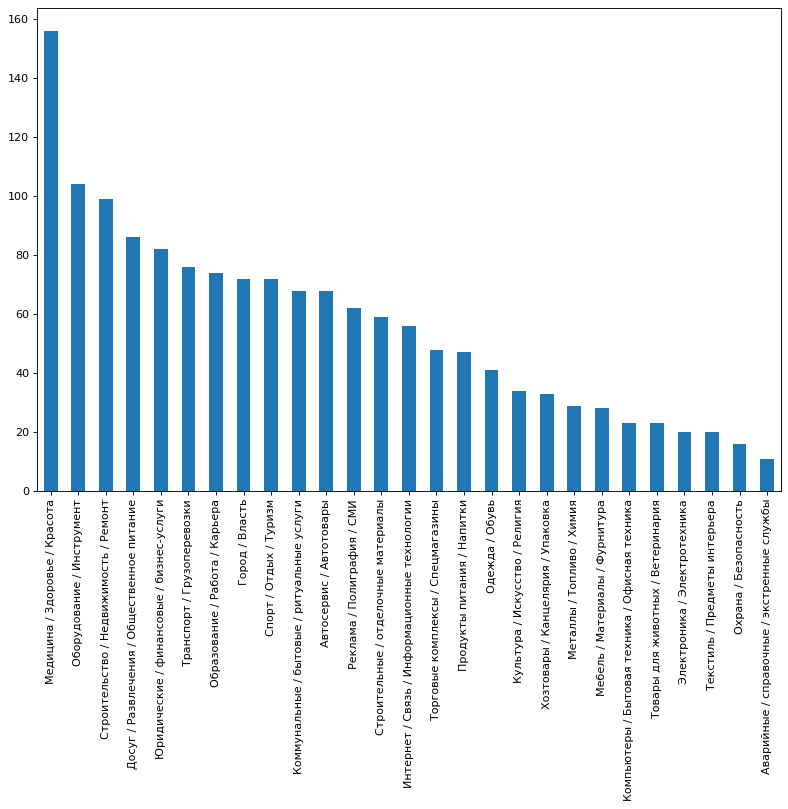

Столбчатая гистограмма данных столбца Рубрика 2го уровня


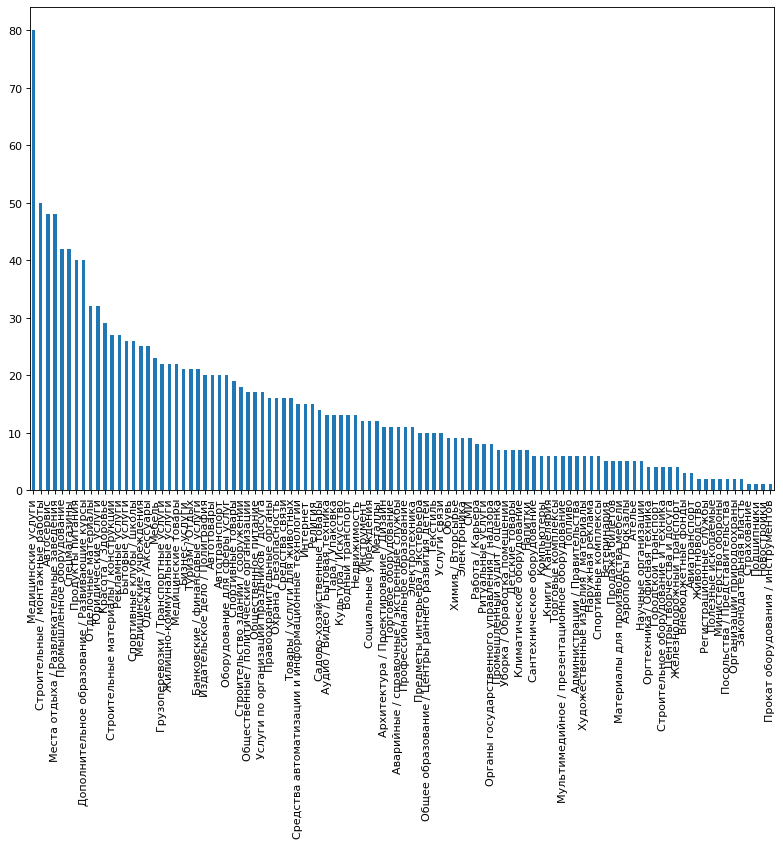

Столбчатая гистограмма данных столбца Категория Пенз область


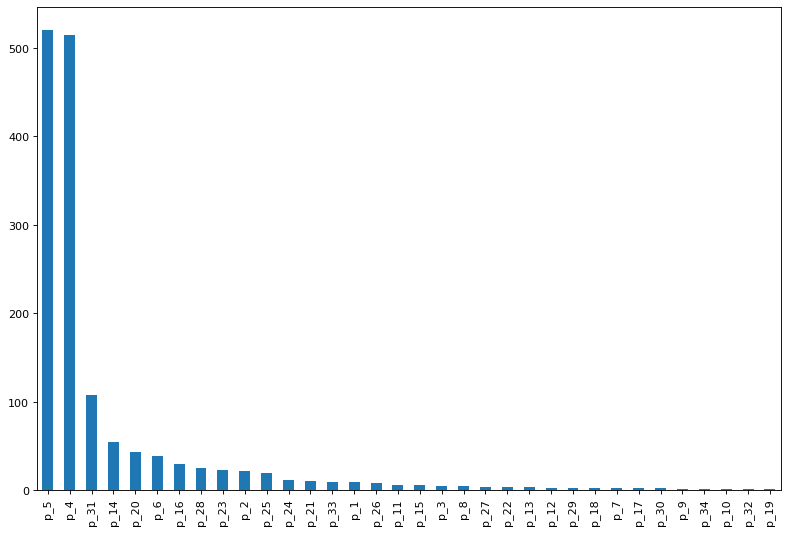

Столбчатая гистограмма данных столбца Категория Лен область


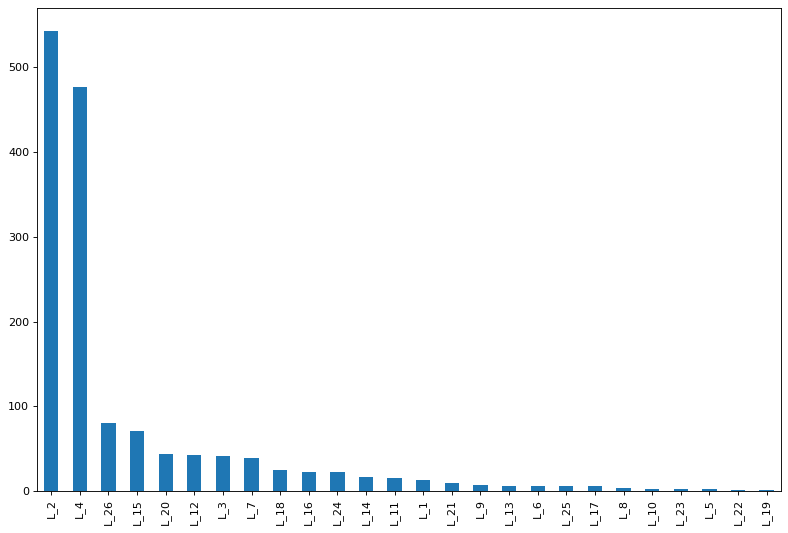

Столбчатая гистограмма данных столбца Категория Респ Бурятия


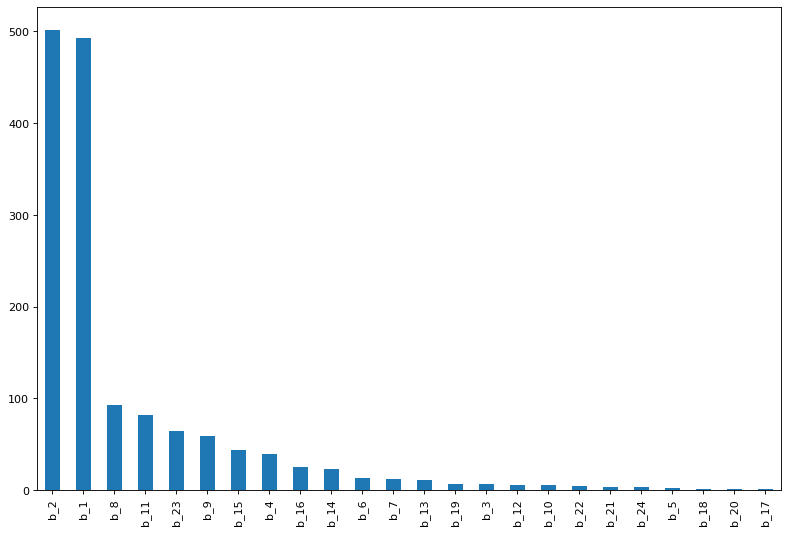

CPU times: user 4.91 s, sys: 448 ms, total: 5.36 s
Wall time: 5.34 s


,Категория,Рубрика 2го уровня,Рубрика,Тематика рубрики,Код рубрики,Ключевые слова,Описание,Категория Пенз область,Категория Лен область,Категория Респ Бурятия
0,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Аварийные службы,Офисные учреждения,122,Аварийка; Аварийная; Аварийная служба; Аварийн...,В данную рубрику следует вносить РАЙОННЫЕ авар...,p_4,L_2,b_1
1,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Ликвидация нефтеразливов / газонефтеводопроявл...,Офисные учреждения,59508,Ликвидация аварийных разливов нефтепродуктов; ...,"В данную рубрику следует вносить организации, ...",p_4,L_2,b_1
2,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Пожарная охрана,Офисные учреждения,143,Пожар; Пожарная служба; Пожарная часть; Пожаро...,В данную рубрику следует вносить районные пожа...,p_4,L_2,b_1
3,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Скорая медицинская помощь,"Больницы, медицина",227,Врач на дом; Вызов врача; Вызов врача на дом; ...,В данную рубрику следует вносить районные подс...,p_31,L_25,b_7
4,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Службы аварийных комиссаров,Офисные учреждения,16182,Аварийные комиссары; Аваркомы; Автокомиссары; ...,В данную рубрику следует вносить службы аварий...,p_4,L_2,b_1


In [11]:
%%time
EDA(gis, ['Категория', 'Рубрика 2го уровня', 'Категория Пенз область', 
             'Категория Лен область', 'Категория Респ Бурятия'])

Итак, что можно увидеть:  
1. столбец "Ключевые слова" имеет ряд пропусков.  
2. Среди всех категорий больше всего значений относятся к медицине. На втором месте, с приличным отставанием идёт категория "Оборудование/Инструмент", завершает тройку лидеров "Строительство/Недвижимость/Ремонт". Меньше всего представлены справочные и экстренные службы.  

3. На столбчатой гистограмме для рубрик 2-го уровня (это подуровень категорий) на первом месте всё так же медицинские услуги, далее идут строительные и монтажные работы, а третье место отдано местам отдыха и развлекательным заведениям.  

4. Далее мы выстроили гистограммы для целевых признаков, которые, собственно, необходимо в будущем определить.  
Чтобы определить, что значат эти индексы, откроем поступательно каждый файл и посмотрим:

<ins>Пенза </ins>

In [12]:
penza = pd.read_excel('нормативы ТКО Пенза.xlsx')
penza

,Код,Наименование категории объектов
0,p_1,"Научно-исследовательские, проектные институты ..."
1,p_2,"Банки, финансовые учреждения"
2,p_3,Отделения связи
3,p_4,"Административные, офисные учреждения"
4,p_5,Предприятия торговли
5,p_6,"Автомастерские, шиномонтажная мастерская, стан..."
6,p_7,Автозаправочные станции
7,p_8,Автостоянки и парковки
8,p_9,"Гаражи, парковки закрытого типа"
9,p_10,Автомойка


Посмотрим на самые популярные и наименее популярное значение:

In [13]:
query_max_min_count(penza, ["p_4", "p_5", "p_32"], 'Категория Пенз область')

,Код,Наименование категории объектов,Количество строк категории в файле 2ГИС
3,p_4,"Административные, офисные учреждения",520
4,p_5,Предприятия торговли,515
31,p_32,"Бани, сауны",1


Итак, для нормативов ТКО Пензенской области первые места занимают категории "Административные, офисные учреждения", второе место - предприятия торговли. Последние 2 столбика на шкале гистограммы - категории "Бани и сауны" и "Иное" (то, что не удалось идентифицировать с файлом df_gis.

<ins>Ленинградская область </ins>

In [14]:
lenobl = pd.read_excel('нормативы ТКО Лен обл.xlsx')
lenobl

,Код,Наименование категории объектов
0,L_1,Административные учреждения (отдельно стоящие ...
1,L_2,"Офисные учреждения, служебные помещения, банки..."
2,L_3,"Продовольственные магазины, магазины алкогольн..."
3,L_4,"Промтоварные магазины, аптеки"
4,L_5,"Супермаркеты (универмаги), магазины смешанной ..."
5,L_6,Железнодорожные и автовокзалы
6,L_7,"Автомастерские, шиномонтажная мастерская, стан..."
7,L_8,"Автомойки, автозаправочные станции"
8,L_9,"Автостоянки, парковки"
9,L_10,Дошкольные образовательные учреждения


In [15]:
query_max_min_count(lenobl, ["L_2", "L_4", "L_19"], 'Категория Лен область')

,Код,Наименование категории объектов,Количество строк категории в файле 2ГИС
1,L_2,"Офисные учреждения, служебные помещения, банки...",543
3,L_4,"Промтоварные магазины, аптеки",477
18,L_19,"Бани, сауны",1


Первую категорию плохо видно:

In [16]:
lenobl[lenobl['Код'] == 'L_2']['Наименование категории объектов'].to_list()

['Офисные учреждения, служебные помещения, банки (расположенные во встроенных помещениях), конструкторские бюро, научно-исследовательские институты, отделения связи']

Что мы видим: категории схожи, но при этом категория административных учреждений находится отдельно, а перед нами офисные учреждения, к которым также отнесли и архивы, и музеи, и библиотеки. А в Пензенской области, например, библиотекам и архивам принадлежит отдельная категория.  
Точно так же и вторая строчка нашей таблицы: "Промтоварные магазины, аптеки". А что в Пензе? Тут вторую строчку рейтинга занимает категория "Предприятия торговли". Как можно заметить, к предприятиям торговли можно отнести и "Промтоварные магазины" (вторая категория Лен обл), и "аптеки" (она же), и "Супермаркеты (универмаги)..." (пятая категория Лен обл), и "Продовольственные магазины" (тоже отдельная категория Лен области).

<ins>Республика Бурятия </ins>

In [17]:
burya = pd.read_excel('нормативы ТКО Бурятия.xlsx')
burya

,Код,Наименование категории объектов
0,b_1,"научно-исследовательские, проектные институты ..."
1,b_2,"продовольственные магазины, промтоварные магаз..."
2,b_3,"супермаркеты (универмаги), рынки продовольстве..."
3,b_4,"автомастерские, шиномонтажные мастерские, стан..."
4,b_5,автозаправочные станции
5,b_6,"железнодорожные и автовокзалы, аэропорты, речн..."
6,b_7,"больницы, санатории, пансионаты, курорты, проф..."
7,b_8,"поликлиники, фармацевтические организации, сто..."
8,b_9,"дошкольные образовательные учреждения, общеобр..."
9,b_10,"детские дома, интернаты"


In [18]:
query_max_min_count(burya, ["b_2", "b_1", "b_17"], 'Категория Респ Бурятия')

,Код,Наименование категории объектов,Количество строк категории в файле 2ГИС
0,b_1,"научно-исследовательские, проектные институты ...",501
1,b_2,"продовольственные магазины, промтоварные магаз...",492
16,b_17,"бани, сауны",1


In [19]:
print(burya[burya['Код'] == 'b_1']['Наименование категории объектов'].to_list())
print()
print(burya[burya['Код'] == 'b_2']['Наименование категории объектов'].to_list())

['научно-исследовательские, проектные институты и конструкторские бюро, банки, финансовые учреждения, административные, офисные учреждения (включая частные охранные организации), отделения связи']

['продовольственные магазины, промтоварные магазины, павильоны торговые (продовольственные, непродовольственные), лотки, палатки, киоски']


Что касается республики Бурятия: в первую категорию помимо НИОКБ отнесены банки и отделения связи.  
Сравним с другими нормативами: 
- в Пензенской области для отделения связи заведена отдельная категория, для банков - тоже. 
- в Лен области банки относят к офисным учреждениям, а отделений связи вообще нет (соответственно, тут может быть только субъективная оценка: либо отнести всё же к офисам, либо вообще к категории "Иное").  

Категория, посвященная сфере торговли, развернуто описана. Видно, что в неё войдут практически все предприятия торговли за исключением рынков и супермаркетов.  
А в Лен области, например, более мелкое деление: для предприятий торговли выделены аж 3 категории.  
Что касается Пензенской области: предприятия торговли все принадлежат к одной категории, при этом никакой расшифровки (что туда относится) внутри нет.

___________________________________________________________________________________________________________________
Таким образом, мы определили, что для решения данной задачи вряд ли подойдет готовый алгоритм вычисления расстояний между текстами, т.к. явных вариаций для разделения нет. Соответственно, решать задачу будем посредством машинного обучения.

Переходим к предобработке данных:

### Предобработка данных

<ins>Работа с пропусками </ins>

Как мы помним, в основном файле пропуски были только в одном столбце:


In [20]:
gis['Ключевые слова'].isna().sum()

19

In [21]:
gis[gis['Ключевые слова'].isna() == True]

,Категория,Рубрика 2го уровня,Рубрика,Тематика рубрики,Код рубрики,Ключевые слова,Описание,Категория Пенз область,Категория Лен область,Категория Респ Бурятия
93,Город / Власть,Общественные / политические организации,Венчурные фонды,Офисные учреждения,112417,NaN,Вносить Венчурные фонды. Венчурный фонд - риск...,p_4,L_2,b_1
94,Город / Власть,Общественные / политические организации,Гарантийные фонды,Офисные учреждения,112416,NaN,Вносить Гарантийные фонды. Также данные органи...,p_4,L_2,b_1
96,Город / Власть,Общественные / политические организации,Гранты,Офисные учреждения,733,NaN,"В данную рубрику следует вносить организации, ...",p_4,L_2,b_1
97,Город / Власть,Общественные / политические организации,Залоговые фонды,Офисные учреждения,112415,NaN,Вносить Залоговые фонды. Залоговый фонд - это ...,p_4,L_2,b_1
102,Город / Власть,Общественные / политические организации,Общественные группы,Офисные учреждения,110878,NaN,Вносить общественные группы с некоммерческой н...,p_4,L_2,b_1
106,Город / Власть,Общественные / политические организации,Приёмные Президента,Офисные учреждения,110949,NaN,В данную рубрику следует вносить приемные През...,p_4,L_2,b_1
139,Город / Власть,Социальные учреждения,Бэби-боксы,"Детские дома, интернаты",110322,NaN,В данную рубрику следует вносить бэби-боксы. \...,p_15,L_13,b_10
167,Досуг / Развлечения / Общественное питание,Места отдыха / Развлекательные заведения,Заповедники,Ботанические сады,112594,NaN,"Вносить заповедники, которые открыты для посещ...",p_21,L_15,b_24
240,Интернет / Связь / Информационные технологии,Интернет,Интернет-провайдеры,Офисные учреждения,176,NaN,"Вносить интернет-провайдеры, которые предостав...",p_4,L_2,b_1
332,Коммунальные / бытовые / ритуальные услуги,Жилищно-коммунальные услуги,Инженерные службы,Офисные учреждения,49532,NaN,В данную рубрику следует вносить инженерные сл...,p_4,L_2,b_1


Поскольку удалять данные нам ни в коем случае нельзя, а столбец предполагается значимым для модели (что мы проверим несколько позже), пропуски мы будем заполнять.
Для этого посмотрим, какие ключевые слова:

In [22]:
gis['Ключевые слова'][1000:1005]

1000    Аренда парусных яхт; Аренда яхт; Парусный спор...
1001    Аренда баскетбольных залов; Аренда баскетбольн...
1002    Басеин; Бассейн для грудничков; Бассейн для де...
1003    Аренда лошадей; Верховая езда; Иподром; Ипподр...
1004    Аренда катка; Городской каток; Катание на конь...
Name: Ключевые слова, dtype: object

In [23]:
gis[1000:1005]

,Категория,Рубрика 2го уровня,Рубрика,Тематика рубрики,Код рубрики,Ключевые слова,Описание,Категория Пенз область,Категория Лен область,Категория Респ Бурятия
1000,Спорт / Отдых / Туризм,Спортивные клубы / школы,Яхт-клубы,Спортивные клубы,9965,Аренда парусных яхт; Аренда яхт; Парусный спор...,Вносить яхт-клубы. Яхт-клубы могут предоставит...,p_20,L_15,b_11
1001,Спорт / Отдых / Туризм,Спортивные комплексы,Аренда спортивных площадок,Спортивные клубы,110498,Аренда баскетбольных залов; Аренда баскетбольн...,"В данную рубрику вносить организации, которые ...",p_20,L_15,b_11
1002,Спорт / Отдых / Туризм,Спортивные комплексы,Бассейны,Спортивные клубы,261,Басеин; Бассейн для грудничков; Бассейн для де...,Вносить плавательные бассейны общего посещения...,p_20,L_15,b_11
1003,Спорт / Отдых / Туризм,Спортивные комплексы,Конные клубы / Ипподромы,Спортивные клубы,262,Аренда лошадей; Верховая езда; Иподром; Ипподр...,В данную рубрику следует вносить специально от...,p_20,L_15,b_11
1004,Спорт / Отдых / Туризм,Спортивные комплексы,Ледовые дворцы / Катки,Спортивные клубы,11974,Аренда катка; Городской каток; Катание на конь...,В данную рубрику следует вносить администрации...,p_20,L_15,b_11


Получается, ключевые слова раскрывают, какие именно виды деятельности компаний относятся к той или иной рубрике.
Что бросается в глаза: столбец "Ключевые слова" отчасти включает в себя данные столбца "Рубрика". Поэтому для отсутствующих значений мы можем заполнить пропуски, взяв информацию из столбца "Рубрика".

In [24]:
gis['Ключевые слова'] = np.where(gis['Ключевые слова'].isna(), gis['Рубрика'], gis['Ключевые слова'])
gis['Ключевые слова'].isna().sum()

0

Идем дальше.
Сделаем предобработку данных и для файла penza:

<ins>Работа с penza </ins>  

Уберем многоквартирные дома, т.к. таких категорий нет в gis:

In [25]:
penza = penza[:-9]

In [26]:
penza.shape

(34, 2)

Очистим текст от знаков препинания и приведем к нижнему регистру:

In [27]:
gis['Ключевые слова clean'] = [clear_text(i) for i in gis['Ключевые слова']]
gis['Тематика рубрики clean'] = [clear_text(i) for i in gis['Тематика рубрики']]

In [28]:
penza['Нормативы clean'] = [clear_text(i) for i in penza['Наименование категории объектов']]

In [29]:
gis['Ключевые слова clean'][0]

'аварийка аварийная аварийная служба аварийно диспетчерские службы аварийно ремонтные службы аварийные диспетчерские службы очистка внешних канализационных сетей промывка внешних канализационных сетей прорвало трубу прочистка внешних канализационных сетей устранение аварий на внешних канализационных сетях устранение засоров на внешних канализационных сетях устранение засоров на дренажах чистка внешних канализационных сетей'

<ins>Работа с BERT </ins>

In [30]:
tokenizer = transformers.BertTokenizer(vocab_file='vocab.txt')
config = transformers.BertConfig.from_json_file('config.json')
model = transformers.BertModel.from_pretrained('bert_model.bin', config=config)

После инициализации модели запустим функцию и получим эмбеддинги:

In [31]:
%%time
x_themes = np.concatenate(bert_preprocessing(gis['Тематика рубрики clean'], 137))
x_themes[:5]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenized head: 0    [101, 109022, 20619, 102]
1    [101, 109022, 20619, 102]
2    [101, 109022, 20619, 102]
3     [101, 21196, 63940, 102]
4    [101, 109022, 20619, 102]
Name: Тематика рубрики clean, dtype: object
Attention mask: (1507, 12)


  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 4min 39s, sys: 24.2 s, total: 5min 3s
Wall time: 3h 15min 34s


array([[-0.04385186, -0.16056873, -0.07360017, ..., -0.03312543,
         0.15670535, -0.15942721],
       [-0.04385186, -0.16056873, -0.07360017, ..., -0.03312543,
         0.15670535, -0.15942721],
       [-0.04385186, -0.16056873, -0.07360017, ..., -0.03312543,
         0.15670535, -0.15942721],
       [ 0.06464411, -0.06243873,  0.14829643, ..., -0.12476775,
         0.20054565, -0.10494517],
       [-0.04385186, -0.16056873, -0.07360017, ..., -0.03312543,
         0.15670535, -0.15942721]], dtype=float32)

In [32]:
%%time
y_penza = np.concatenate(bert_preprocessing(penza['Нормативы clean'], 17))
y_penza[:5]

Tokenized head: 0    [101, 14498, 56797, 110081, 29580, 851, 104191...
1                      [101, 25067, 26715, 20619, 102]
2                              [101, 14526, 6766, 102]
3                     [101, 37591, 109022, 20619, 102]
4                             [101, 14950, 17646, 102]
Name: Нормативы clean, dtype: object
Attention mask: (34, 25)


  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 17.2 s, sys: 125 ms, total: 17.3 s
Wall time: 825 ms


array([[ 0.04077337, -0.0715507 , -0.18409133, ..., -0.05790344,
         0.14963962, -0.09355889],
       [ 0.01207565, -0.22463864, -0.03972396, ..., -0.01408637,
         0.1322862 , -0.09822364],
       [ 0.05335537, -0.01654769, -0.12114376, ..., -0.05479141,
         0.18204255, -0.0225163 ],
       [-0.03308176, -0.14506552, -0.06498611, ...,  0.0110901 ,
         0.153224  , -0.14751604],
       [-0.05768543, -0.14386213, -0.24893358, ...,  0.03618791,
         0.15779416,  0.0243752 ]], dtype=float32)

<ins>Работа с регионами </ins>

Точно так же поступим и с другими субъектами:

In [33]:
lenobl['Нормативы clean'] = [clear_text(i) for i in lenobl['Наименование категории объектов']]
burya['Нормативы clean'] = [clear_text(i) for i in burya['Наименование категории объектов']]

In [34]:
lenobl = lenobl[:26]
burya = burya[:24]

Провекторизуем:

In [35]:
%%time
Len = np.concatenate(bert_preprocessing(lenobl['Нормативы clean'], 26))
Len[:5]

Tokenized head: 0    [101, 37591, 20619, 25044, 66114, 11680, 68637...
1    [101, 109022, 20619, 59608, 23475, 25067, 2926...
2    [101, 104357, 30010, 30010, 42600, 1438, 852, ...
3     [101, 7710, 42461, 874, 2059, 30010, 90405, 102]
4    [101, 107014, 880, 110461, 852, 30010, 15090, ...
Name: Нормативы clean, dtype: object
Attention mask: (26, 26)


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 12.4 s, sys: 61.1 ms, total: 12.5 s
Wall time: 606 ms


array([[ 0.33951405, -0.65672535,  0.01697491, ...,  0.15788794,
        -0.04169584,  0.5247994 ],
       [-0.43554148, -0.7094851 , -0.19812635, ...,  0.27621725,
         0.27276272,  0.33375317],
       [-0.12259095, -0.72831523,  0.08435969, ...,  0.46263313,
        -0.35280514,  0.20283715],
       [-0.05799618, -0.28238767, -0.18290788, ...,  0.10878397,
        -0.14796253,  0.16613923],
       [-0.19096413, -0.18899919, -0.11718786, ...,  0.17367291,
        -0.00329576,  0.29351717]], dtype=float32)

In [36]:
%%time
B = np.concatenate(bert_preprocessing(burya['Нормативы clean'], 24))
B[:5]

Tokenized head: 0    [101, 14498, 56797, 110081, 29580, 851, 104191...
1    [101, 104357, 30010, 7710, 42461, 874, 2059, 3...
2    [101, 107014, 880, 110461, 852, 40214, 104357,...
3    [101, 6459, 48944, 3648, 45368, 71998, 15328, ...
4                      [101, 81753, 15020, 10326, 102]
Name: Нормативы clean, dtype: object
Attention mask: (24, 38)


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 16.4 s, sys: 11.7 ms, total: 16.4 s
Wall time: 783 ms


array([[-0.10313828, -0.5457427 , -0.04044467, ...,  0.48098117,
         0.50191885,  0.5298844 ],
       [ 0.00150194, -0.18133563,  0.33977675, ...,  0.28147548,
        -0.3024087 , -0.00542802],
       [ 0.04977332, -0.30518416,  0.19810385, ...,  0.40823805,
        -0.13519496,  0.09934096],
       [-0.09186438, -0.06133232,  0.10549966, ...,  0.21182686,
         0.01697924,  0.10458817],
       [ 0.00475546, -0.08615337, -0.17906958, ...,  0.15486106,
         0.21057148, -0.12140346]], dtype=float32)

Добавим новые столбцы с матрицами:

In [37]:
gis['theme_matrix'] = list(x_themes)

In [38]:
penza['norm_matrix']  = list(y_penza)
lenobl['norm_matrix_l']  = list(Len)
burya['norm_matrix_b']  = list(B)

<ins>Работа с косинусным расстоянием </ins>

Вызовем функцию вычисления косинусного расстояния: 

In [39]:
ind_p, maximum_p = cos_similarity('theme_matrix', penza['norm_matrix'])

И функцию-подготовку к расчёту F1 -меры:

In [40]:
F1_p = f1_score(gis['Категория Пенз область'], real_values(penza, ind_p), average='micro')
print("F1-мера для Пензенской области: {}, ".format(F1_p))

F1-мера для Пензенской области: 0.72992700729927, 


Достаточно приличный показатель, учитывая, что мы только вычислили угол между векторами, не подключая нейросети.  
Пришло время подключить.

### Работа с моделью

Для начала <ins>формируем тренировочный и тестовый датасеты </ins>

Сформируем новый датафрейм, в который положим нужные нам столбцы:

In [41]:
gis = gis.reset_index()

In [42]:
gis_nn = gis[['index', 'Тематика рубрики clean', 'theme_matrix', 'Категория Пенз область', 'Категория Лен область', 'Категория Респ Бурятия']]
gis_nn['Код'] = real_values(penza, ind_p)
gis_nn.head()

,index,Тематика рубрики clean,theme_matrix,Категория Пенз область,Категория Лен область,Категория Респ Бурятия,Код
0,0,офисные учреждения,"[-0.04385186, -0.16056873, -0.07360017, -0.050...",p_4,L_2,b_1,p_4
1,1,офисные учреждения,"[-0.04385186, -0.16056873, -0.07360017, -0.050...",p_4,L_2,b_1,p_4
2,2,офисные учреждения,"[-0.04385186, -0.16056873, -0.07360017, -0.050...",p_4,L_2,b_1,p_4
3,3,больницы медицина,"[0.06464411, -0.062438726, 0.14829643, 0.05309...",p_31,L_25,b_7,p_31
4,4,офисные учреждения,"[-0.04385186, -0.16056873, -0.07360017, -0.050...",p_4,L_2,b_1,p_4


Выведем новый столбец, где 1 будет означать, что предсказание верно, 0 - ошибочно:

In [43]:
list_check = []
for i in range(len(gis_nn)):
    if gis_nn.loc[i, 'Категория Пенз область'] == gis_nn.loc[i, 'Код']:
        list_check.append(1)
    else:
        list_check.append(0)
gis_nn['check'] = list_check

In [44]:
penza = penza.rename({'Код':'Категория Пенз область'}, axis=1)
lenobl = lenobl.rename({'Код':'Категория Лен область'}, axis=1)
burya = burya.rename({'Код':'Категория Респ Бурятия'}, axis=1)

Сделаем одну общую сводную таблицу. Добавим столбцы из penza, lenobl и burya:

In [45]:
ind_len, maximum_len = cos_similarity('theme_matrix', lenobl['norm_matrix_l'])
ind_b, maximum_b = cos_similarity('theme_matrix', burya['norm_matrix_b'])

In [46]:
gis_nn = gis_nn.merge(penza[['Категория Пенз область', 'Нормативы clean', 'norm_matrix']], how='left', on='Категория Пенз область')
gis_nn = gis_nn.merge(lenobl[['Категория Лен область', 'Нормативы clean', 'norm_matrix_l']], how='left', on='Категория Лен область')
gis_nn = gis_nn.merge(burya[['Категория Респ Бурятия', 'Нормативы clean', 'norm_matrix_b']], how='left', on='Категория Респ Бурятия')
gis_nn.head()

,index,Тематика рубрики clean,theme_matrix,Категория Пенз область,Категория Лен область,Категория Респ Бурятия,Код,check,Нормативы clean_x,norm_matrix,Нормативы clean_y,norm_matrix_l,Нормативы clean,norm_matrix_b
0,0,офисные учреждения,"[-0.04385186, -0.16056873, -0.07360017, -0.050...",p_4,L_2,b_1,p_4,1,административные офисные учреждения,"[-0.033081755, -0.14506552, -0.06498611, -0.05...",офисные учреждения служебные помещения банки р...,"[-0.43554148, -0.7094851, -0.19812635, -0.4488...",научно исследовательские проектные институты и...,"[-0.10313828, -0.5457427, -0.040444672, 0.0735..."
1,1,офисные учреждения,"[-0.04385186, -0.16056873, -0.07360017, -0.050...",p_4,L_2,b_1,p_4,1,административные офисные учреждения,"[-0.033081755, -0.14506552, -0.06498611, -0.05...",офисные учреждения служебные помещения банки р...,"[-0.43554148, -0.7094851, -0.19812635, -0.4488...",научно исследовательские проектные институты и...,"[-0.10313828, -0.5457427, -0.040444672, 0.0735..."
2,2,офисные учреждения,"[-0.04385186, -0.16056873, -0.07360017, -0.050...",p_4,L_2,b_1,p_4,1,административные офисные учреждения,"[-0.033081755, -0.14506552, -0.06498611, -0.05...",офисные учреждения служебные помещения банки р...,"[-0.43554148, -0.7094851, -0.19812635, -0.4488...",научно исследовательские проектные институты и...,"[-0.10313828, -0.5457427, -0.040444672, 0.0735..."
3,3,больницы медицина,"[0.06464411, -0.062438726, 0.14829643, 0.05309...",p_31,L_25,b_7,p_31,1,медицина,"[0.07283858, -0.0049156696, 0.054700598, 0.020...",больницы санатории,"[0.08408094, -0.041841306, -0.09902477, 0.0380...",больницы санатории пансионаты курорты профилак...,"[0.16526353, -0.1712561, -0.031467497, 0.25091..."
4,4,офисные учреждения,"[-0.04385186, -0.16056873, -0.07360017, -0.050...",p_4,L_2,b_1,p_4,1,административные офисные учреждения,"[-0.033081755, -0.14506552, -0.06498611, -0.05...",офисные учреждения служебные помещения банки р...,"[-0.43554148, -0.7094851, -0.19812635, -0.4488...",научно исследовательские проектные институты и...,"[-0.10313828, -0.5457427, -0.040444672, 0.0735..."


Добавим столбец с расстоянием:

In [47]:
gis_nn['similarity'] = maximum_p
gis_nn[40:50]

,index,Тематика рубрики clean,theme_matrix,Категория Пенз область,Категория Лен область,Категория Респ Бурятия,Код,check,Нормативы clean_x,norm_matrix,Нормативы clean_y,norm_matrix_l,Нормативы clean,norm_matrix_b,similarity
40,40,автомастерские шиномонтаж,"[0.022821754, -0.05860745, -0.1384775, 0.01466...",p_6,L_7,b_4,p_27,0,автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажные мастерские станци...,"[-0.09186438, -0.061332323, 0.105499655, -0.03...",0.987058
41,41,автомастерские шиномонтаж,"[0.022821754, -0.05860745, -0.1384775, 0.01466...",p_6,L_7,b_4,p_27,0,автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажные мастерские станци...,"[-0.09186438, -0.061332323, 0.105499655, -0.03...",0.987058
42,42,автомастерские шиномонтаж,"[0.022821754, -0.05860745, -0.1384775, 0.01466...",p_6,L_7,b_4,p_27,0,автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажные мастерские станци...,"[-0.09186438, -0.061332323, 0.105499655, -0.03...",0.987058
43,43,автомастерские шиномонтаж,"[0.022821754, -0.05860745, -0.1384775, 0.01466...",p_6,L_7,b_4,p_27,0,автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажные мастерские станци...,"[-0.09186438, -0.061332323, 0.105499655, -0.03...",0.987058
44,44,автомастерские шиномонтаж,"[0.022821754, -0.05860745, -0.1384775, 0.01466...",p_6,L_7,b_4,p_27,0,автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажные мастерские станци...,"[-0.09186438, -0.061332323, 0.105499655, -0.03...",0.987058
45,45,автомастерские шиномонтаж,"[0.022821754, -0.05860745, -0.1384775, 0.01466...",p_6,L_7,b_4,p_27,0,автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажные мастерские станци...,"[-0.09186438, -0.061332323, 0.105499655, -0.03...",0.987058
46,46,автомастерские шиномонтаж,"[0.022821754, -0.05860745, -0.1384775, 0.01466...",p_6,L_7,b_4,p_27,0,автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажная мастерская станци...,"[-0.14432116, -0.24837685, 0.013832614, 0.0197...",автомастерские шиномонтажные мастерские станци...,"[-0.09186438, -0.061332323, 0.105499655, -0.03...",0.987058
47,47,автозаправочные станции,"[0.0047554597, -0.08615337, -0.17906958, 0.112...",p_7,L_8,b_5,p_7,1,автозаправочные станции,"[0.0047554597, -0.08615337, -0.17906958, 0.112...",автомойки автозаправочные станции,"[-0.18466225, -0.44616067, 0.17031291, 0.22349...",автозаправочные станции,"[0.0047554597, -0.08615337, -0.17906958, 0.112...",1.000000
48,48,промтоварный магазин,"[0.009990752, 0.06435412, -0.08837518, -0.0142...",p_5,L_4,b_2,p_5,1,предприятия торговли,"[-0.057685435, -0.14386213, -0.24893358, 0.108...",промтоварные магазины аптеки,"[-0.05799618, -0.28238767, -0.18290788, -0.110...",продовольственные магазины промтоварные магази...,"[0.0015019439, -0.18133563, 0.33977675, 0.1707...",0.980461
49,49,автомастерские шиномонтаж,"[0.022821754, -0.05860745, -0.1384775, 0.01466...",p_6,L_7,b_4,p_27,0,автомастерские шиномонтажная мастерска

Разделим датафрейм на 2 части: тренировочную, тестовую:

In [48]:
X = gis_nn[['index', 'Категория Пенз область', 'theme_matrix', 'norm_matrix']]
y = gis_nn.check

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, )

Теперь разделим X_train и X_test на X1_train и Z1_train и X2_test и Z2_test:

In [49]:
X1_train = np.reshape(np.array([np.array(i) for i in X_train['theme_matrix']]), (1009, 1, 768))
Z1_train = np.reshape(np.array([np.array(i) for i in X_train['norm_matrix']]), (1009, 1, 768))

X1_test = np.reshape(np.array([np.array(i) for i in X_test['theme_matrix']]), (498, 1, 768))
Z1_test = np.reshape(np.array([np.array(i) for i in X_test['norm_matrix']]), (498, 1, 768))

y_train = np.reshape(np.array(y_train), (1009, 1))
y_test = np.reshape(np.array(y_test), (498, 1))

Теперь построим модель нейросети:

In [50]:
def NNCreate():
    inp1 = Input(shape=(None,768))
    x1 = LSTM(64,return_sequences = True)(inp1)
    x1 = Dropout(DROPOUT)(x1)
    x1 = LSTM(64,return_sequences = False)(x1)
    x1 = Dropout(DROPOUT)(x1)

    inp2 = Input(shape=(None,768))
    x2 = LSTM(64,return_sequences = True)(inp2)
    x2 = Dropout(DROPOUT)(x2)
    x2 = LSTM(64,return_sequences = False)(x2)
    x2 = Dropout(DROPOUT)(x2)
    
    merge = Concatenate()([x1, x2])
    out1 = Dense(128)(merge)
    out = Dense(y_train.shape[1])(out1)
    imodel = Model(inputs=[inp1,inp2], outputs=out)
    plot_model(imodel, to_file='mynet.png')  # сохраним дерево модели
    return(imodel)

In [51]:
DROPOUT = 0.1
nnet = NNCreate()
nnet.compile(optimizer=Adam(learning_rate=1e-05), loss = 'mean_absolute_error')

try_history = nnet.fit([X1_train,Z1_train], y_train, epochs = 100, batch_size = 128,verbose=1)
tf.keras.models.save_model(nnet, 'NNLSTM.h5')
curr_loss=try_history.history['loss']

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/100
8/8 [==============================] - 8s 15ms/step - loss: 0.7364
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7239
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7198
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7155
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7081
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.6885
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7006
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7076
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 0.6760
Epoch 10/100
8/8 [==============================] - 0s 13ms/step - loss: 0.6768
Epoch 11/100
8/8 [==============================] - 0s 12ms/s

Предскажем значения для Пензы:

In [52]:
%%time
pred_penza = predict_sim(X1_test, Z1_test, penza, 'Категория Пенз область')

F1_p = f1_score(gis['Категория Пенз область'], pred_penza['Код'], average='micro')
print('F1-метрика для')
print('Пензенская область: {}'.format(F1_p))
pred_penza[20:30]

F1-метрика для
Пензенская область: 0.900464499004645
CPU times: user 30.3 s, sys: 811 ms, total: 31.1 s
Wall time: 29 s


,Рубрика,Норматив,Код
20,Газовое оборудование для автотранспорта,Предприятия торговли,p_5
21,Детейлинг,"Административные, офисные учреждения",p_4
22,Заправочные станции,Автозаправочные станции,p_7
23,Компьютерная диагностика автомобилей,Автостоянки и парковки,p_8
24,Кузовной ремонт,"Автомастерские, шиномонтажная мастерская, стан...",p_6
25,Мобильные АЗС,Автозаправочные станции,p_7
26,Переоборудование автомобилей,"Автомастерские, шиномонтажная мастерская, стан...",p_6
27,Пошив авточехлов / автоковров,Предприятия торговли,p_5
28,Пункты технического осмотра транспорта,"Автомастерские, шиномонтажная мастерская, стан...",p_6
29,Развал / Схождение,"Автомастерские, шиномонтажная мастерская, стан...",p_6


И построим график функции потерь:

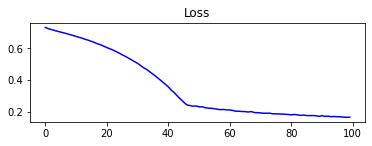

In [53]:
summarize_diagnostics([try_history])

In [54]:
X = np.reshape(np.array([list(i) for i in gis_nn['theme_matrix']]), (1507, 1, 768))
X.shape

(1507, 1, 768)

In [55]:
Len = np.reshape(np.array([list(i) for i in gis_nn['norm_matrix_l']]), (1507, 1, 768))
Len.shape

(1507, 1, 768)

In [56]:
B = np.reshape(np.array([list(i) for i in gis_nn['norm_matrix_b']]), (1507, 1, 768))
B.shape

(1507, 1, 768)

In [57]:
%%time
pred_lenobl = predict_sim(X, Len, lenobl, 'Категория Лен область')

F1_l = f1_score(gis['Категория Лен область'], pred_lenobl['Код'], average='micro')
print('F1-метрика для')
print('Ленинградская область: {}'.format(F1_l))
pred_lenobl[20:30]

F1-метрика для
Ленинградская область: 0.8533510285335103
CPU times: user 1min 28s, sys: 2.14 s, total: 1min 30s
Wall time: 1min 25s


,Рубрика,Норматив,Код
20,Газовое оборудование для автотранспорта,"Промтоварные магазины, аптеки",L_4
21,Детейлинг,"Автомастерские, шиномонтажная мастерская, стан...",L_7
22,Заправочные станции,"Автомойки, автозаправочные станции",L_8
23,Компьютерная диагностика автомобилей,"Автомастерские, шиномонтажная мастерская, стан...",L_7
24,Кузовной ремонт,"Автомастерские, шиномонтажная мастерская, стан...",L_7
25,Мобильные АЗС,"Автомойки, автозаправочные станции",L_8
26,Переоборудование автомобилей,"Автомастерские, шиномонтажная мастерская, стан...",L_7
27,Пошив авточехлов / автоковров,"Промтоварные магазины, аптеки",L_4
28,Пункты технического осмотра транспорта,"Автомастерские, шиномонтажная мастерская, стан...",L_7
29,Развал / Схождение,"Автомастерские, шиномонтажная мастерская, стан...",L_7


In [58]:
%%time
pred_burya = predict_sim(X, B, burya, 'Категория Респ Бурятия')

F1_b = f1_score(gis['Категория Респ Бурятия'], pred_burya['Код'], average='micro')
print('F1-метрика для')
print('Республика Бурятия: {}'.format(F1_b))
pred_burya[20:30]

F1-метрика для
Республика Бурятия: 0.8394160583941606
CPU times: user 1min 27s, sys: 1.94 s, total: 1min 29s
Wall time: 1min 23s


,Рубрика,Норматив,Код
20,Газовое оборудование для автотранспорта,"продовольственные магазины, промтоварные магаз...",b_2
21,Детейлинг,"автомастерские, шиномонтажные мастерские, стан...",b_4
22,Заправочные станции,автозаправочные станции,b_5
23,Компьютерная диагностика автомобилей,"автомастерские, шиномонтажные мастерские, стан...",b_4
24,Кузовной ремонт,"автомастерские, шиномонтажные мастерские, стан...",b_4
25,Мобильные АЗС,автозаправочные станции,b_5
26,Переоборудование автомобилей,"автомастерские, шиномонтажные мастерские, стан...",b_4
27,Пошив авточехлов / автоковров,"продовольственные магазины, промтоварные магаз...",b_2
28,Пункты технического осмотра транспорта,"автомастерские, шиномонтажные мастерские, стан...",b_4
29,Развал / Схождение,"автомастерские, шиномонтажные мастерские, стан...",b_4


### Выводы  

**Цель** дипломной работы - сравнить рубрики и нормативы с семантической точки зрения и подтянуть к файлу с рубриками схожие нормативы.  
На основе цели формировались задачи, которые послужили планом работы.  
- На первом этапе проведен исследовательский анализ данных, где установлено, что категории нормообразующих предприятий ТКО в разных субъектах РФ могут незначительно отличаться, соответственно, определить данную тему как проблему классификации не представляется возможным. При этом ввиду различий в нормативах категории основного файла могут быть соотнесены с разными нормативами.  
- Вторым пунктом плана стала предобработка данных. В ходе выполнения задачи были заполнены пропуски (поскольку удалять объекты не представлялось возможным); определены основные тематики рубрик; удалены лишние нормативы из файла penza. Далее данные были предобработаны с помощью BERT Tokenizer. При этом от файла gis был взят максимально приближенный к данным нормативов столбец с тематиками рубрик, от файла penza взят единственно возможный столбец - наименования категории объектов. Итогом этапа предобработки данных стал расчёт косинусного расстояния между всеми возможными вариантами сочетания категорий и нормативов. Варианты, получившие максимальную оценку, определены в новый датафрейм и отмечены "1". Объекты, оказавшиеся ошибочно соотнесенными, отмечены "0". Аналогично проведена предобработка и для таблиц с нормативами Ленинградской области и республики Бурятия.    
- На следующем этапе построена и обучена модель нейросети, которая определяет расстояние между всеми возможными вариантами. Для обучения модели были взяты 3 столбца: массивы категорий, массивы нормативов, а также метки правильности ответа. По итогам обучения модели определены остальные 28% данных тренировочного образца, расчитанного при помощи ресурсов библиотеки sklearn (вычисления косинусного расстояния). На тестовых данных файла нормативов Пензенской области (те 27% неправильных ответов) результат: 0,90.  

При определении новых данных для модели - нормативов других двух регионов - метрика F1 составила: 0,85 и  0,83 соответственно.   
Таким образом, цель достигнута. В перспективе планируется углубить модель и потренировать ее при помощи других текстовых столбцов основных данных.